### 임베딩 계층 테스트

### RNN 계층 구현

In [ ]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid


class MyRNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = t #np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next #dh_next * (1 - h_next ** 2)
        
        db = np.sum(dt, axis=0)
        print('db=', db)
        dWh = np.dot(h_prev.T, dt)
        print('dWh=', dWh)
        dh_prev = np.dot(dt, Wh.T)
        print('dh_prev=', dh_prev)
        dWx = np.dot(x.T, dt)
        print('dWx=' , dWx)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### 케라스를 이용한 RNN 모델 구현

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

In [2]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [3]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [5]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
print(x_train_all[0])    

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [6]:
word_to_index = imdb.get_word_index()
word_to_index['movie']

17

In [7]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [8]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [9]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [10]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [11]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [12]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [13]:
print(x_train_seq[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [14]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [15]:
print(x_train_onehot.shape)

(20000, 100, 100)


In [30]:
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [31]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 4s 6ms/step - loss: 0.7051 - accuracy: 0.4958 - val_loss: 0.6975 - val_accuracy: 0.5062
Epoch 2/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6946 - accuracy: 0.5160 - val_loss: 0.6893 - val_accuracy: 0.5392
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6832 - accuracy: 0.5613 - val_loss: 0.6755 - val_accuracy: 0.5842
Epoch 4/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6660 - accuracy: 0.5976 - val_loss: 0.6667 - val_accuracy: 0.5942
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6481 - accuracy: 0.6258 - val_loss: 0.6331 - val_accuracy: 0.6442
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6335 - accuracy: 0.6411 - val_loss: 0.6203 - val_accuracy: 0.6576
Epoch 7/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6225 - accuracy: 0.6573 - val_loss: 0.6241 - val_accuracy: 0.6428
Epoch 

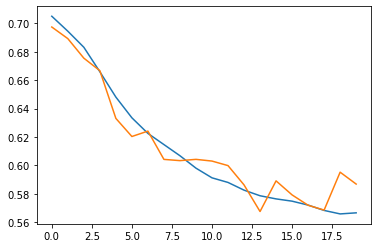

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

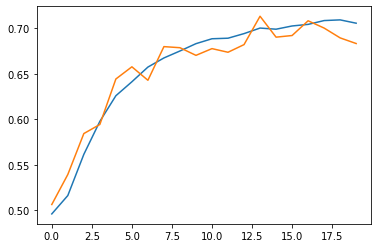

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [35]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)
print(accuracy)

0.6832000017166138


In [36]:
from tensorflow.keras.layers import Embedding

In [37]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [38]:
maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [39]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 328       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                        validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.5689 - accuracy: 0.6970 - val_loss: 0.5262 - val_accuracy: 0.7398
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.4561 - accuracy: 0.7973 - val_loss: 0.4935 - val_accuracy: 0.7808
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4237 - accuracy: 0.8169 - val_loss: 0.4800 - val_accuracy: 0.7902
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3960 - accuracy: 0.8324 - val_loss: 0.4812 - val_accuracy: 0.7900
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3607 - accuracy: 0.8490 - val_loss: 0.4919 - val_accuracy: 0.7854
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3421 - accuracy: 0.8583 - val_loss: 0.4923 - val_accuracy: 0.7908
Epoch 7/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3160 - accuracy: 0.8737 - val_loss: 0.4752 - val_accuracy: 0.8052
Epoch 

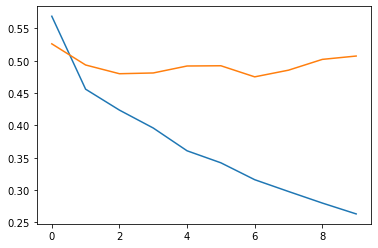

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

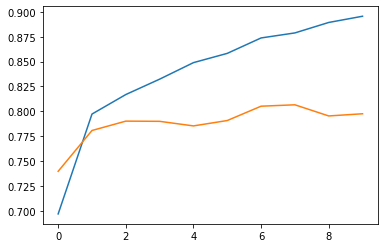

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [43]:
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.7975999712944031


In [44]:
from tensorflow.keras.layers import LSTM

In [45]:
model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 lstm (LSTM)                 (None, 8)                 1312      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                         validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 7s 10ms/step - loss: 0.4636 - accuracy: 0.7902 - val_loss: 0.3773 - val_accuracy: 0.8382
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3348 - accuracy: 0.8593 - val_loss: 0.3673 - val_accuracy: 0.8356
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3066 - accuracy: 0.8722 - val_loss: 0.3530 - val_accuracy: 0.8430
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2914 - accuracy: 0.8782 - val_loss: 0.3850 - val_accuracy: 0.8388
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2738 - accuracy: 0.8856 - val_loss: 0.3628 - val_accuracy: 0.8408
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2588 - accuracy: 0.8939 - val_loss: 0.3685 - val_accuracy: 0.8400
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2466 - accuracy: 0.8971 - val_loss: 0.3921 - val_accuracy: 0.8374

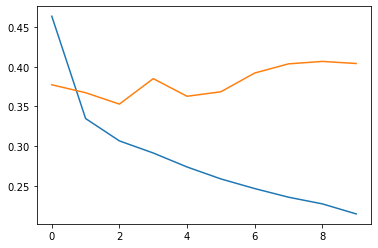

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

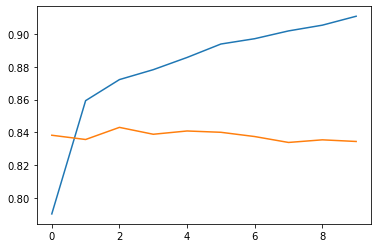

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [49]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8343999981880188
